In [1]:
import keras
from keras.datasets import mnist
from keras.models import load_model
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

from functools import partial

from collections import defaultdict

import isolearn.keras as iso

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import tensorflow as tf

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()


Using TensorFlow backend.


In [2]:
#Load MNIST data

dataset_name = "mnist_3_vs_5"

img_rows, img_cols = 28, 28

num_classes = 10
batch_size = 32

included_classes = { 3, 5 }

(x_train, y_train), (x_test, y_test) = mnist.load_data()

keep_index_train = []
for i in range(y_train.shape[0]) :
    if y_train[i] in included_classes :
        keep_index_train.append(i)

keep_index_test = []
for i in range(y_test.shape[0]) :
    if y_test[i] in included_classes :
        keep_index_test.append(i)

x_train = x_train[keep_index_train]
x_test = x_test[keep_index_test]
y_train = y_train[keep_index_train]
y_test = y_test[keep_index_test]

n_train = int((x_train.shape[0] // batch_size) * batch_size)
n_test = int((x_test.shape[0] // batch_size) * batch_size)
x_train = x_train[:n_train]
x_test = x_test[:n_test]
y_train = y_train[:n_train]
y_test = y_test[:n_test]


x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print("x_train.shape = " + str(x_train.shape))

print("n train samples = " + str(x_train.shape[0]))
print("n test samples = " + str(x_test.shape[0]))

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#Binarize images

def _binarize_images(x, val_thresh=0.5) :
    
    x_bin = np.zeros(x.shape)
    x_bin[x >= val_thresh] = 1.
    
    return x_bin

x_train = _binarize_images(x_train, val_thresh=0.5)
x_test = _binarize_images(x_test, val_thresh=0.5)

digit_train = np.argmax(y_train, axis=1)
digit_test = np.argmax(y_test, axis=1)


x_train.shape = (11552, 28, 28, 1)
n train samples = 11552
n test samples = 1888


In [3]:
#Load predictor model

predictor = Sequential()

predictor.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, name='conv2d_1'))
predictor.add(Conv2D(64, (3, 3), activation='relu', name='conv2d_2'))
predictor.add(MaxPooling2D(pool_size=(2, 2)))
predictor.add(Dropout(0.25))
predictor.add(Flatten())
predictor.add(Dense(128, activation='relu', name='dense_1'))
predictor.add(Dropout(0.5))
predictor.add(Dense(num_classes, activation='softmax', name='dense_2'))

predictor.load_weights('saved_models/mnist_binarized_cnn_10_digits.h5')
predictor.trainable = False

predictor.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adadelta(),
    metrics=['accuracy']
)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [4]:
#Generate (original) predictions

pred_train = predictor.predict(x_train, batch_size=32)
pred_test = predictor.predict(x_test, batch_size=32)


In [5]:
###########################################
####################L2X####################
###########################################

from keras.callbacks import ModelCheckpoint
from keras.models import Model, Sequential 

import numpy as np
import tensorflow as tf

from keras.layers import MaxPooling2D, Flatten, Conv2D, Input, GlobalMaxPooling2D, Multiply, Lambda, Embedding, Dense, Dropout, Activation
from keras.datasets import imdb
from keras import backend as K  
from keras.engine.topology import Layer 

# Define various Keras layers.
class Concatenate1D(Layer):
    """
    Layer for concatenation. 

    """
    def __init__(self, **kwargs): 
        super(Concatenate1D, self).__init__(**kwargs)

    def call(self, inputs):
        input1, input2 = inputs  
        input1 = tf.expand_dims(input1, axis = -2) # [batchsize, 1, input1_dim] 
        dim1 = int(input2.get_shape()[1])
        input1 = tf.tile(input1, [1, dim1, 1])
        return tf.concat([input1, input2], axis = -1)

    def compute_output_shape(self, input_shapes):
        input_shape1, input_shape2 = input_shapes
        input_shape = list(input_shape2)
        input_shape[-1] = int(input_shape[-1]) + int(input_shape1[-1])
        input_shape[-2] = int(input_shape[-2])
        return tuple(input_shape)

class Concatenate2D(Layer):
    """
    Layer for concatenation. 

    """
    def __init__(self, **kwargs): 
        super(Concatenate2D, self).__init__(**kwargs)

    def call(self, inputs):
        input1, input2 = inputs  
        input1 = tf.expand_dims(tf.expand_dims(input1, axis = -2), axis = -2) # [batchsize, 1, 1, input1_dim] 
        dim1 = int(input2.get_shape()[1])
        dim2 = int(input2.get_shape()[2])
        input1 = tf.tile(input1, [1, dim1, dim2, 1])
        return tf.concat([input1, input2], axis = -1)

    def compute_output_shape(self, input_shapes):
        input_shape1, input_shape2 = input_shapes
        input_shape = list(input_shape2)
        input_shape[-1] = int(input_shape[-1]) + int(input_shape1[-1])
        input_shape[-2] = int(input_shape[-2])
        input_shape[-3] = int(input_shape[-3])
        return tuple(input_shape)

class Sample_Concrete(Layer):
    """
    Layer for sample Concrete / Gumbel-Softmax variables. 

    """
    def __init__(self, tau0, k, **kwargs): 
        self.tau0 = tau0
        self.k = k
        super(Sample_Concrete, self).__init__(**kwargs)

    def call(self, logits):   
        # logits: [batch_size, d, 1]
        logits_ = K.permute_dimensions(logits, (0,2,1))# [batch_size, 1, d]
        
        d = int(logits_.get_shape()[2])
        unif_shape = [batch_size,self.k,d]

        uniform = K.random_uniform_variable(shape=unif_shape,
            low = np.finfo(tf.float32.as_numpy_dtype).tiny,
            high = 1.0)
        gumbel = - K.log(-K.log(uniform))
        noisy_logits = (gumbel + logits_)/self.tau0
        samples = K.softmax(noisy_logits)
        samples = K.max(samples, axis = 1) 
        logits = tf.reshape(logits,[-1, d]) 
        threshold = tf.expand_dims(tf.nn.top_k(logits, self.k, sorted = True)[0][:,-1], -1)
        discrete_logits = tf.cast(tf.greater_equal(logits,threshold),tf.float32)

        output = K.in_train_phase(samples, discrete_logits) 
        return tf.expand_dims(output,-1)

    def compute_output_shape(self, input_shape):
        return input_shape

def construct_gumbel_selector(X_ph, n_filters=32, n_dense_units=32):
    """
    Build the L2X model for selection operator. 

    """
    first_layer = Conv2D(n_filters, (3, 3), padding='same', activation='relu', strides=1, name = 'conv1_gumbel')(X_ph)    

    # global info
    net_new = GlobalMaxPooling2D(name = 'new_global_max_pooling1d_1')(first_layer)
    global_info = Dense(n_dense_units, name = 'new_dense_1', activation='relu')(net_new) 

    # local info
    net = Conv2D(n_filters, (3, 3), padding='same', activation='relu', strides=1, name = 'conv2_gumbel')(first_layer) 
    local_info = Conv2D(n_filters, (3, 3), padding='same', activation='relu', strides=1, name = 'conv3_gumbel')(net)  
    combined = Concatenate2D()([global_info,local_info]) 
    net = Dropout(0.2, name = 'new_dropout_2')(combined)
    net = Conv2D(n_filters, (1, 1), padding='same', activation='relu', strides=1, name = 'conv_last_gumbel')(net)   

    logits_T = Conv2D(1, (1, 1), padding='same', activation=None, strides=1, name = 'conv4_gumbel')(net)  

    return logits_T


def L2X(x_train, y_train, pred_train, x_val, y_val, pred_val, k=10, batch_size=32, epochs=5, hidden_dims=250): 
    """
    Generate scores on features on validation by L2X.

    Train the L2X model with variational approaches 
    if train = True. 

    """
    
    Mean1D = Lambda(lambda x, k=k: K.sum(x, axis = 1) / float(k), output_shape=lambda x: [x[0],x[2]]) 

    Mean2D = Lambda(lambda x, k=k: K.sum(x, axis = (1, 2)) / float(k), output_shape=lambda x: [x[0],x[3]]) 
    
    print('Creating model...')

    # P(S|X)
    with tf.variable_scope('selection_model'):
        X_ph = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))

        logits_T = construct_gumbel_selector(X_ph)
        tau = 0.5
        
        #Extra code: Flatten 2D
        orig_logits_T = logits_T
        logits_T = Lambda(lambda x: K.reshape(x, (K.shape(x)[0], x_train.shape[1] * x_train.shape[2], 1)))(logits_T)
        
        T = Sample_Concrete(tau, k)(logits_T)
        
        #Extra code: Inflate 2D
        T = Lambda(lambda x: K.reshape(x, (K.shape(x)[0], x_train.shape[1], x_train.shape[2], 1)))(T)

    # q(X_S)
    with tf.variable_scope('prediction_model'):
        
        #Same architecture as original predictor
        
        net = Multiply()([X_ph, T])
        net = Conv2D(32, (3, 3), padding='same', activation='relu')(net)
        net = Conv2D(64, (3, 3), padding='same', activation='relu')(net)
        net = MaxPooling2D(pool_size=(2, 2))(net)
        net = Dropout(0.25)(net)
        net = Flatten()(net)
        net = Dense(hidden_dims, activation='relu')(net)
        net = Dropout(0.5)(net)
        preds = Dense(pred_train.shape[1], activation='softmax', name = 'new_dense')(net)
        
        '''
        #Default approximator
        
        net = Mean2D(Multiply()([X_ph, T]))
        net = Dense(hidden_dims)(net)
        net = Dropout(0.2)(net)
        net = Activation('relu')(net) 
        preds = Dense(pred_train.shape[1], activation='softmax', name = 'new_dense')(net)
        '''


    model = Model(inputs=X_ph, outputs=preds)

    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc']) 
    train_acc = np.mean(np.argmax(pred_train, axis = 1)==np.argmax(y_train, axis = 1))
    val_acc = np.mean(np.argmax(pred_val, axis = 1)==np.argmax(y_val, axis = 1))
    print('The train and validation accuracy of the original model is {} and {}'.format(train_acc, val_acc))

    print(model.summary())
    
    checkpoint = ModelCheckpoint("saved_models/l2x.hdf5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    model.fit(x_train, pred_train, 
        validation_data=(x_val, pred_val), 
        callbacks=[checkpoint],
        epochs=5, batch_size=batch_size
    )

    model.load_weights('saved_models/l2x.hdf5', by_name=True) 

    pred_model = Model([X_ph], [orig_logits_T, preds])
    pred_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    
    pred_model.load_weights('saved_models/l2x.hdf5', by_name=True) 

    scores, q = pred_model.predict(x_val, verbose=1, batch_size=batch_size)
    
    return scores, q


In [6]:
#Create two-channel patterns for MNIST images

x_train_two = np.concatenate([
    1. - x_train,
    x_train
], axis=-1)

x_test_two = np.concatenate([
    1. - x_test,
    x_test
], axis=-1)


In [7]:
#Execute L2X

k = int(np.ceil(0.05 * 28 * 28))
batch_size = 32
hidden_dims = 128#250
epochs = 5

importance_scores_test, q_test = L2X(
    x_train_two,
    y_train,
    pred_train,
    x_test_two,
    y_test,
    pred_test,
    k=k,
    batch_size=batch_size,
    epochs=epochs,
    hidden_dims=hidden_dims
)


Creating model...
The train and validation accuracy of the original model is 0.9967105263157895 and 0.9936440677966102
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 2)    0                                            
__________________________________________________________________________________________________
conv1_gumbel (Conv2D)           (None, 28, 28, 32)   608         input_1[0][0]                    
__________________________________________________________________________________________________
new_global_max_pooling1d_1 (Glo (None, 32)           0           conv1_gumbel[0][0]               
__________________________________________________________________________________________________
conv2_gumbel (Conv2D)           (None, 28, 28, 32)   9248        conv1_gumbel[0][0]      

Test image 0:


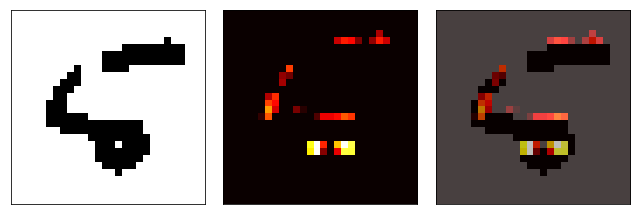

Test image 1:


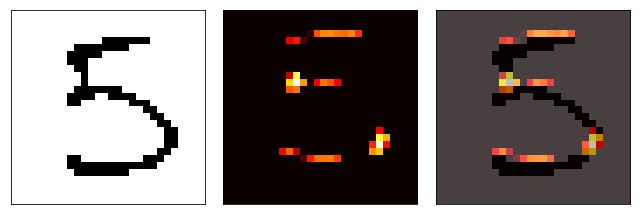

Test image 2:


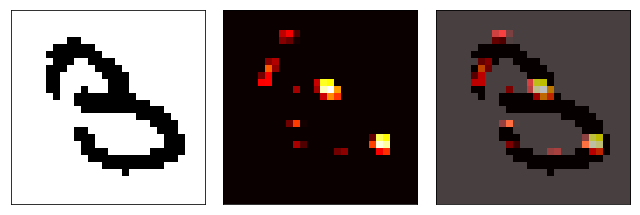

Test image 3:


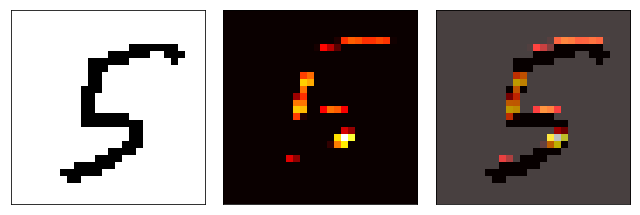

Test image 4:


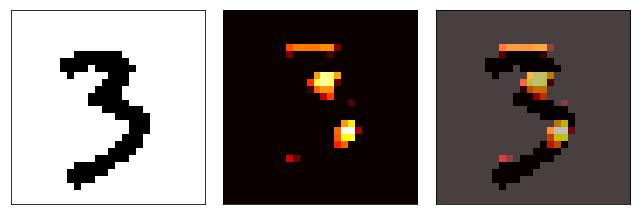

Test image 5:


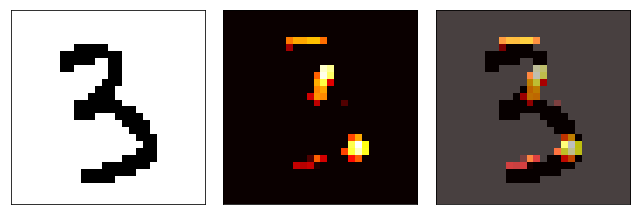

Test image 6:


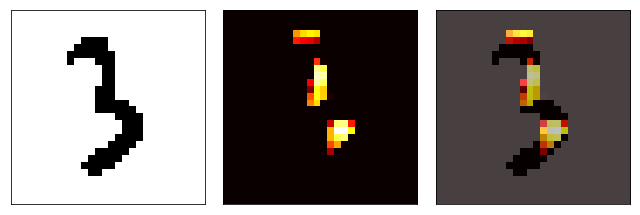

Test image 7:


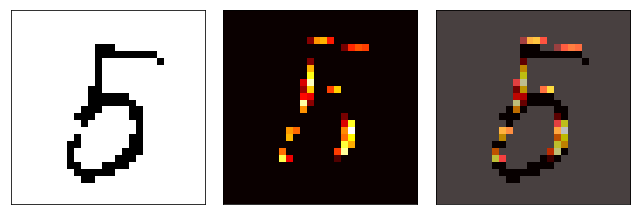

Test image 8:


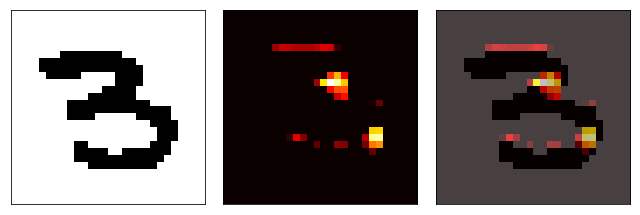

Test image 9:


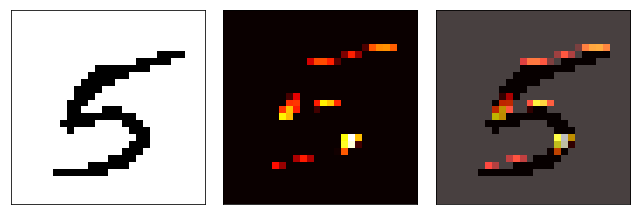

In [8]:
#Visualize a few images

for plot_i in range(0, 10) :
    
    print("Test image " + str(plot_i) + ":")
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3 * 3, 3))

    ax1.imshow(x_test[plot_i, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    plt.sca(ax1)
    plt.xticks([], [])
    plt.yticks([], [])
    
    #ax2.imshow(importance_scores_test[plot_i, :, :, 0], cmap="hot", vmin=0.0, vmax=max(1e-7, np.max(importance_scores_test[plot_i, :, :, 0])), aspect='equal')
    
    vmin = np.quantile(importance_scores_test[plot_i, :, :, 0], q=1. - float(k)/float(28*28))
    vmax = np.max(importance_scores_test[plot_i, :, :, 0])
    
    ax2.imshow(importance_scores_test[plot_i, :, :, 0], cmap="hot", vmin=vmin, vmax=vmax, aspect='equal')

    plt.sca(ax2)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax3.imshow(x_test[plot_i, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    #ax3.imshow(importance_scores_test[plot_i, :, :, 0], alpha=0.75, cmap="hot", vmin=0.0, vmax=max(1e-7, np.max(importance_scores_test[plot_i, :, :, 0])), aspect='equal')
    ax3.imshow(importance_scores_test[plot_i, :, :, 0], alpha=0.75, cmap="hot", vmin=vmin, vmax=vmax, aspect='equal')

    plt.sca(ax3)
    plt.xticks([], [])
    plt.yticks([], [])

    plt.tight_layout()
    plt.show()


In [9]:
#Save predicted importance scores

model_name = "l2x_" + dataset_name

np.save(model_name + "_importance_scores_test", importance_scores_test)
